In [4]:
from packages import *
from utils import *
from losses import *
from datasets import *
from models import *

In [2]:
df = pd.read_csv('../Data/reproducibility.csv').sample(frac=1, random_state=1).reset_index(drop=True)
df.head()

,peptide,peptide_aromaticity,peptide_gravy,peptide_helix,peptide_instability_index,peptide_isoelectric_point,peptide_len,peptide_log_len,peptide_log_weight,peptide_mean,...,protein_isoelectric_point,protein_len,protein_log_len,protein_log_weight,protein_molar_extinction_coefficient,protein_sheet,protein_turn,protein_weight,reproducibility,reproducibility_corrected
0,SELTQQLNALFQDK,0.071429,-0.742857,0.285714,39.107143,4.368781,14,2.639057,7.399267,21.571060,...,5.985737,480,6.173786,10.925809,14900.0,0.372917,0.162500,55592.8205,0.134116,-0.416929
1,EETGQVLER,0.000000,-1.288889,0.222222,27.300000,4.252773,9,2.197225,6.966134,23.123484,...,5.803739,613,6.418365,11.114425,114625.0,0.225122,0.295269,67132.6103,0.118270,-0.276561
2,QLYGDTGVLGR,0.090909,-0.263636,0.363636,-20.009091,5.835682,11,2.397895,7.071824,22.152872,...,6.581580,184,5.214936,9.929104,22982.5,0.288043,0.163043,20518.9427,0.730757,-0.019208
3,EVQVFEITENSAK,0.076923,-0.415385,0.307692,33.061538,4.252773,13,2.564949,7.308954,18.674903,...,5.255015,188,5.236442,9.948520,4470.0,0.218085,0.202128,20921.2417,0.245870,0.106907
4,EDYICYAR,0.250000,-0.662500,0.375000,62.425000,4.370430,8,2.079442,6.939377,23.851474,...,4.550382,127,4.844187,9.523820,18450.0,0.188976,0.377953,13681.7806,0.768097,0.377618


In [5]:
class ResultsContainer:
    def __init__(self, path=None):
        self.container = defaultdict(
            lambda: defaultdict(
                lambda: dict(
                    optim_history=[],
                    params=defaultdict(list),
                    results=defaultdict(list),
                )
            )
        )
        if path is not None:
            self.load(path)
            
    def update_from_list(self, exp_name, optim_history, params, results):
        for model_name in optim_history:
            self.update(exp_name, model_name,
                        optim_history[model_name],
                        params[model_name],
                        results[model_name])
            
    def update(self, exp_name, model_name, optim_history, params, results):
        self.container[exp_name][model_name]['optim_history'].append(optim_history)
        for k, v in params.items():
            self.container[exp_name][model_name]['params'][k].append(v)
        for k, v in results.items():
            self.container[exp_name][model_name]['results'][k].append(v)
        
    def save(self, path):
        pickle.dump(self.to_dict(), open(path, 'wb'))
        
    def load(self, path):
        self.container.update(pickle.load(open(path, 'rb')))
        
    def update_file(self, path):
        container = ResultsContainer(path)
        container_new = self.container
        for exp_name, models in container_new.items():
            for model_name, model_container in models.items():
                container[exp_name][model_name] = model_container
        container.save(path)

    def to_dict(self):
        return self.rec_to_dict(self.container)
    
    def rec_to_dict(self, d):
        if type(d)!=defaultdict and type(d)!=dict:
            return d
        for k, v in d.items():
            if type(v)==defaultdict or type(v)==dict:
                d[k] = self.rec_to_dict(v)
        return dict(d)
    
    def __getitem__(self, key):
        return self.container[key]
    
    
class Objective:
    def __init__(self, x, y, groups, model_getter, Dataset, collate, epochs=100, early_stop=10):
        self.x = x
        self.y = y
        self.groups = groups
        self.Dataset = Dataset
        self.collate = collate
        self.get_model = model_getter
        self.epochs = epochs
        self.early_stop = early_stop

    def __call__(self, space):
        params = space.copy()
        batch_size = params['batch_size']
        del params['batch_size']
        model = self.get_model(**params)
        
        loader_params = {
            'Dataset': self.Dataset,
            'collate': self.collate,
            'batch_size': batch_size,
        }
        scores = parallel_net_cross_val(model, self.x, self.y, loader_params,
                                        groups=self.groups, kf=GroupKFold(),
                                        epochs=self.epochs, early_stop=self.early_stop)
        return scores.mean()


def optimize_models(x, y, groups, optim_params, exp_params, evals=1, epochs=1, early_stop=10):
    optim_results, history_results = {}, {}
    for model_name, model_params in optim_params.items():
        params, history = optimize(
            objective=Objective(x, y, groups,
                                model_getter=model_params['model_getter'],
                                **exp_params, epochs=epochs, early_stop=early_stop),
            space=model_params['space'],
            mapping=model_params['mapping'],
            evals=evals
        )
        optim_results[model_name] = params
        history_results[model_name] = history
    return optim_results, history_results

def evaluate(x_train, y_train, x_test, y_test, model_getter, params, exp_params, epochs=1, early_stop=10):
    params = params.copy()
    batch_size = params['batch_size']
    del params['batch_size']
    model = model_getter(**params)
    train_loader, test_loader = get_loaders(x_train, y_train,
                                            x_test, y_test,
                                            batch_size=batch_size,
                                            **exp_params)
    model.train(train_loader, epochs=epochs, early_stop=early_stop, verbose=False)
    # Get preds and targets
    preds_train, targets_train = model.predict_from_loader(train_loader, to_numpy=True)
    preds_test, targets_test = model.predict_from_loader(test_loader, to_numpy=True)
    # Get metrics
    metrics = dict(
        MSE=mean_squared_error,
        MAE=mean_absolute_error,
        R2=r2_score,
        EV=explained_variance_score
    )
    results = {}
    for metric, func in metrics.items():
        results['Train '+metric] = func(targets_train, preds_train)
        results['Test '+metric] = func(targets_test, preds_test)
    return results


def compare_models(x_train, y_train, x_test, y_test,
                   optim_params, optim_results, epx_params,
                   epochs=1, early_stop=10):
    results = {}
    for model_name, model_params in optim_params.items():
        model_getter = optim_params[model_name]['model_getter']
        results[model_name] = evaluate(
            x_train, y_train, x_test, y_test,
            model_getter, optim_results[model_name],
            exp_params, epochs, early_stop
        )
    return results

def run_experiment(x, y, groups, exp_name, exp_params, optim_params,
                   evals, epochs, early_stop=10):
    container = ResultsContainer()
    kf = GroupKFold()
    for train_index, test_index in kf.split(x, y, groups):
        # Get train/test data
        x_train, y_train, groups_train = x[train_index], y[train_index], groups[train_index]
        x_test, y_test = x[test_index], y[test_index]
        # Run optimization
        params, history = optimize_models(x_train, y_train, groups_train,
                                          optim_params, exp_params, evals=evals,
                                          epochs=epochs, early_stop=early_stop)
        # Run model comparison
        results = compare_models(x_train, y_train, x_test, y_test,
                                 optim_params, params, exp_params,
                                 epochs=epochs, early_stop=early_stop)
        # Store results
        container.update_from_list(exp_name, history, params, results)
    return container

# Seq experiment

In [4]:
exp_name = 'Seq'
exp_params = dict(
    Dataset=PeptideDataset,
    collate=Collate(),
)
optim_params = {}

### GRU

In [23]:
def gru_getter(output_dim, num_layers, dropout, lr, weight_decay, optimizer):
    net = nn.Sequential(
        RecurrentEncoder(
            input_dim=len(aminoacids)+2,
            embedding_dim=output_dim//2,
            output_dim=output_dim,
            bidirectional=True,
            rnn_type='gru',
            pool_type='avg',
            num_layers=num_layers, 
            dropout=dropout,
        ),
        nn.Dropout(dropout),
        nn.Linear(output_dim, 1),
        nn.Sigmoid()
    ).to(device)
    
    if optimizer == 'sgd':
        optim = torch.optim.SGD(net.parameters(), lr=lr,
                                momentum=0.9, nesterov=True, 
                                weight_decay=weight_decay)
    else:
        optim = torch.optim.AdamW(net.parameters(), lr=lr,
                                  weight_decay=weight_decay)
    model = Network(
        net=net,
        optimizer=optim,
        loss=nn.BCELoss(),
        gamma=0.97
    )
    return model

gru_space = {
    'output_dim': hyperopt.hp.qloguniform('output_dim', np.log(4), np.log(128), 4),
    'num_layers': hyperopt.hp.quniform('num_layers', 1, 3, 1),
    'dropout': hyperopt.hp.uniform('dropout', 0, 0.5),
    'batch_size': hyperopt.hp.qloguniform('batch_size', np.log(8), np.log(128), 4),
    'lr': hyperopt.hp.loguniform('lr', np.log(1e-5), np.log(0.1)),
    'weight_decay': hyperopt.hp.loguniform('weight_decay', np.log(1e-5), np.log(1)),
    'optimizer': hyperopt.hp.choice('optimizer', [0, 1])
}
gru_mapping = dict(
    output_dim=lambda x: int(x),
    num_layers=lambda x: int(x),
    batch_size=lambda x: int(x),
    optimizer=lambda x: ['sgd', 'adam'][x]
)

optim_params['GRU'] = dict(
    model_getter=gru_getter,
    space=gru_space,
    mapping=gru_mapping,
)

### CNNGRU

In [5]:
def cnngru_getter(output_dim, num_layers, dropout, lr, weight_decay, optimizer):
    net = nn.Sequential(
        ConvolutionalRecurrentEncoder(
            input_dim=len(aminoacids)+2,
            output_dim=output_dim,
            bidirectional=True,
            num_layers=num_layers,
            dropout=dropout,
        ),
        nn.Dropout(dropout),
        nn.Linear(output_dim, 1),
        nn.Sigmoid(),
    )
    
    if optimizer == 'sgd':
        optim = torch.optim.SGD(net.parameters(), lr=lr,
                                momentum=0.9, nesterov=True, 
                                weight_decay=weight_decay)
    else:
        optim = torch.optim.AdamW(net.parameters(), lr=lr,
                                  weight_decay=weight_decay)
    model = Network(
        net=net,
        optimizer=optim,
        loss=nn.BCELoss(),
        gamma=0.97
    )
    return model
        
cnngru_space = {
    'output_dim': hyperopt.hp.qloguniform('output_dim', np.log(4), np.log(128), 4),
    'num_layers': hyperopt.hp.quniform('num_layers', 1, 3, 1),
    'dropout': hyperopt.hp.uniform('dropout', 0, 0.5),
    'batch_size': hyperopt.hp.qloguniform('batch_size', np.log(8), np.log(256), 4),
    'lr': hyperopt.hp.loguniform('lr', np.log(1e-4), np.log(0.1)),
    'weight_decay': hyperopt.hp.loguniform('weight_decay', np.log(1e-5), np.log(1)),
    'optimizer': hyperopt.hp.choice('optimizer', [0, 1])
}
cnngru_mapping = dict(
    output_dim=lambda x: int(x),
    num_layers=lambda x: int(x),
    batch_size=lambda x: int(x),
    optimizer=lambda x: ['sgd', 'adam'][x]
)

optim_params['CNNGRU'] = dict(
    model_getter=cnngru_getter,
    space=cnngru_space,
    mapping=cnngru_mapping,
)

### BERT

In [26]:
def bert_getter(output_dim, num_layers, dropout, lr, weight_decay, optimizer):
    net = nn.Sequential(
        TransformerEncoder(
            input_dim=len(aminoacids)+2,
            output_dim = output_dim,
            hidden_dim = output_dim*2,
            kind='bert',
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout
        ),
        nn.Dropout(dropout),
        nn.Linear(output_dim, 1),
        nn.Sigmoid()
    ).to(device)
    
    if optimizer == 'sgd':
        optim = torch.optim.SGD(net.parameters(), lr=lr,
                                momentum=0.9, nesterov=True, 
                                weight_decay=weight_decay)
    else:
        optim = torch.optim.AdamW(net.parameters(), lr=lr,
                                  weight_decay=weight_decay)
    model = Network(
        net=net,
        optimizer=optim,
        loss=nn.BCELoss(),
        gamma=0.97
    )
    return model
        
bert_space = {
    'output_dim': hyperopt.hp.qloguniform('output_dim', np.log(4), np.log(128), 4),
    'num_layers': hyperopt.hp.quniform('num_layers', 1, 3, 1),
    'num_heads': hyperopt.hp.quniform('num_layers', 1, 4, 2),
    'dropout': hyperopt.hp.uniform('dropout', 0, 0.5),
    'batch_size': hyperopt.hp.qloguniform('batch_size', np.log(8), np.log(256), 4),
    'lr': hyperopt.hp.loguniform('lr', np.log(1e-4), np.log(0.1)),
    'weight_decay': hyperopt.hp.loguniform('weight_decay', np.log(1e-5), np.log(1)),
    'optimizer': hyperopt.hp.choice('optimizer', [0, 1])
}
bert_mapping = dict(
    output_dim=lambda x: int(x),
    num_layers=lambda x: int(x),
    num_heads=lambda x: int(x),
    batch_size=lambda x: int(x),
    optimizer=lambda x: ['sgd', 'adam'][x]
)

optim_params['BERT'] = dict(
    model_getter=bert_getter,
    space=bert_space,
    mapping=bert_mapping,
)

## Run Experiment

In [30]:
models = [
    'GRU',
#     'CNNGRU',
#     'BERT',
]

optim_params = {k:optim_params[k] for k in models}

In [ ]:
x = df['peptide'].values
y = df['reproducibility'].values
groups = LabelEncoder().fit_transform(df['protein_id'])

container = run_experiment(x, y, groups, exp_name, exp_params, optim_params,
                           evals=20, epochs=100, early_stop=10)
container.update_file('../Results/reproducibility_results.pkl')

In [33]:
container = ResultsContainer('../Results/reproducibility_results.pkl')
d = container.to_dict()['Seq']['GRU']

In [11]:
container = ResultsContainer('../Results/reproducibility_results.pkl')
results = container.to_dict()['Counts']['MLPRegressor']
r_df = pd.DataFrame(results['optim_history'][0])
for i in range(1, len(results['optim_history'])):
    r_df = r_df.append(pd.DataFrame(results['optim_history'][i]))

In [10]:
results['params']

{'solver': ['sgd', 'sgd', 'sgd', 'sgd', 'sgd'],
 'learning_rate': ['adaptive', 'adaptive', 'adaptive', 'adaptive', 'adaptive'],
 'alpha': [0.22664481543348095,
  0.16648384598661986,
  0.11598428285538719,
  0.09058212693378193,
  0.08096285207287178],
 'batch_size': [44, 24, 20, 32, 16],
 'hidden_layer_sizes': [84, 66, 100, 14, 108],
 'learning_rate_init': [0.021101764145474947,
  0.026335816236399065,
  0.16481890178553008,
  0.053174671343138316,
  0.05393078542349629]}

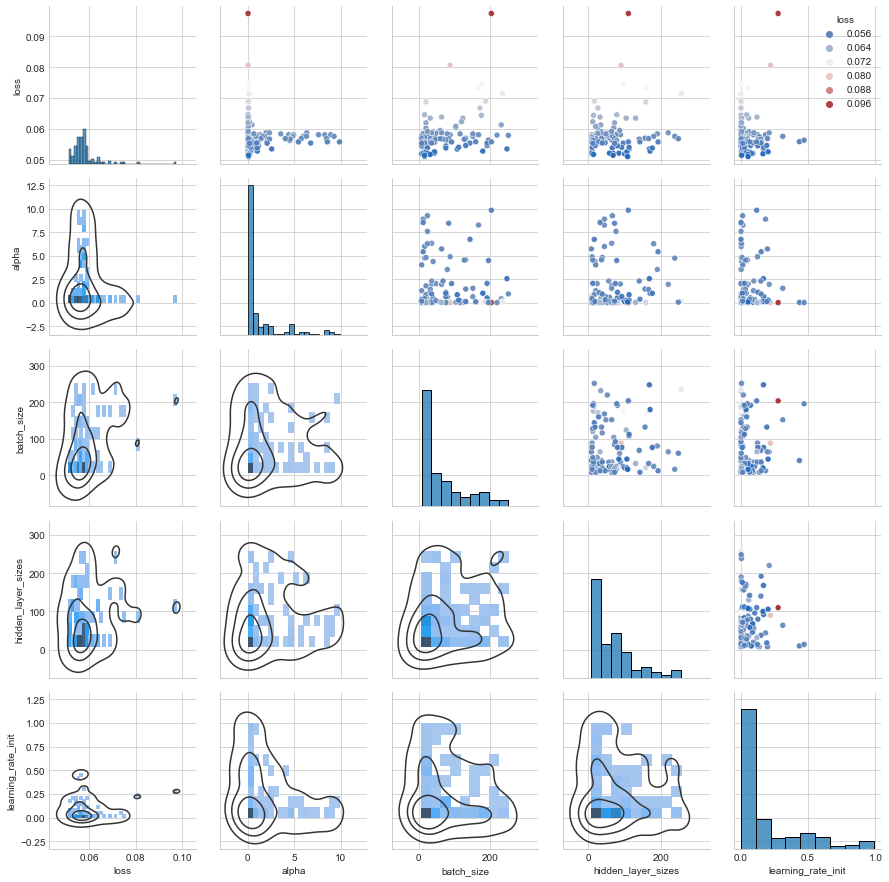

In [7]:
g = sns.PairGrid(r_df)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot, hue=r_df['loss'], palette='vlag')
g.map_lower(sns.histplot)
g.map_lower(sns.kdeplot, levels=4, color='0.2')
g.axes[0, -1].legend(loc='best', bbox_to_anchor=(1, 1), title='loss')

In [2]:
all_to_one()